<a href="https://colab.research.google.com/github/masadeghi/EHRsample/blob/main/nn_tensorflow_with_model_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import dependencies**

In [1]:
import pandas as pd
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

# Set tensorflow random seed
tf.random.set_seed(42)

# **Import data**

1. Download the data from this link (You'll need to sign up in the PhysioNet website and sign a data use agreement.'): https://physionet.org/content/heart-failure-zigong/1.3/#files
2. Upload the .zip file to your google drive. (Here, I've uploaded the file to a folder named "databases" in my Google drive)
3. Read the datasets into pandas dataframes.

In [2]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip the .zip file containing all the datasets
!unzip gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip

Archive:  gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/LICENSE.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/SHA256SUMS.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv  


In [4]:
# Read the datasets into pandas dataframes
patient_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv', index_col = 0)
treatment_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv', index_col = 0)
dict_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv', index_col = 0)

# **Exploratory data analysis and feature engineering**

## Step 1: Restructure the treatment data
One-hot encode the `treatment_data` dataset so that treatment data (drugs administered to the patients during their hospitalization) could be concatenated with the clinical and lab data (`patient_data` dataset).

In [5]:
# Initialize zeros matrix with desired dimensions, indexes, and column names
drugs = np.zeros((len(patient_data['inpatient.number'].unique()),
                  len(treatment_data['Drug_name'].unique())))

drugs = pd.DataFrame(drugs, index = patient_data['inpatient.number'].unique(), columns = treatment_data['Drug_name'].unique())

# Iterate over the rows and columns of the constructed matrix and repalce 0 with 1
# in the appropriate column if the treatment was administered.
for index, row in drugs.iterrows():
  for col in drugs.columns:
    subset = treatment_data.loc[treatment_data['inpatient.number'] == index, 'Drug_name']
    if col in subset.values:
      drugs.loc[index, col] = 1

# Concatenate the resulting matrix with the main dataset:
# Total data (t_data) = main dataset + drug data
patient_data.set_index('inpatient.number', inplace = True)

t_data = pd.concat([patient_data, drugs], axis = 1)

## Step 2: Explore the features

* Identify features with missing data.
* Explore each feature to understand its data structure.

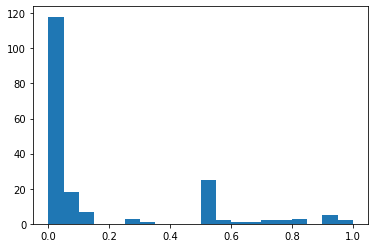

In [6]:
# Determining the extent of missing data in the dataset
missing_perc = []

for i, col in enumerate(t_data.columns):
  percentage = t_data[col].isnull().mean()
  missing_perc.append((i, col, percentage))

missing_perc.sort(key = lambda x: x[2], reverse = True)

plt.hist([i[2] for i in missing_perc], bins = 20)
plt.show()

In [7]:
# Explore each variable
def summary(colname):
  col = t_data[colname]

  print(col[:5])

  if col.dtype == object:
    print('\n Unique factors: \n', col.unique())
    print('\n', col.describe(include = 'object'))
  else:
    print('\n', col.describe())

summary("dischargeDay")

857781    11
743087     8
866418     5
775928    11
810128     5
Name: dischargeDay, dtype: int64

 count    2008.000000
mean        9.420817
std         8.030256
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max       123.000000
Name: dischargeDay, dtype: float64


## Step 3: Split data into predictor (`X`) and target (`y`) datasets
* Log transform `y` to make it's distribution closer to normal.

In [8]:
y = t_data['dischargeDay']
X = t_data.drop('dischargeDay', axis = 1)

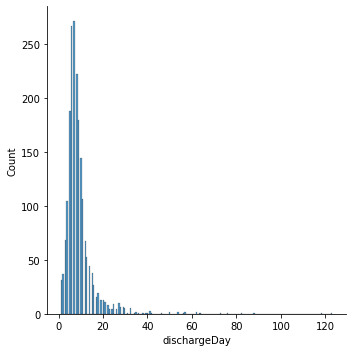

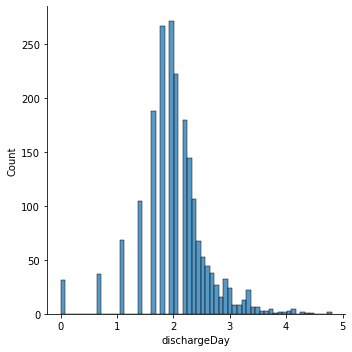

In [9]:
# log transform y
import seaborn as sns
sns.displot(y)
y = np.log(y)
sns.displot(y)

## Step 4: Remove features that aren't useful in a practical setting
Explore the features in `X` to classify them into the following categories:

*   Features that are expected to be available at the time of admission or a short while after (e.g., preliminary lab data)
*   Features that are expected to be available only at the time of discharge
*   Features from echocardiography
*   Features that are expected to be available only after patient discharge and on patient follow-up

For predicting duration of hospital stay, only the first category could be useful in a clinical setting.

In [10]:
# Features only availble at the time of discharge
discharge_var = ['DestinationDischarge', 'discharge.department', 'outcome.during.hospitalization']

# Features only available after discharge and on patient follow-up
future_var = ['death.within.28.days', 're.admission.within.28.days', 'death.within.3.months',
              're.admission.within.3.months', 'death.within.6.months', 're.admission.within.6.months',
              'time.of.death..days.from.admission.', 're.admission.time..days.from.admission.',
              'return.to.emergency.department.within.6.months', 'time.to.emergency.department.within.6.months']

# Features only available after an echocardiography
echo_var = ['LVEF', 'left.ventricular.end.diastolic.diameter.LV',
            'mitral.valve.EMS', 'mitral.valve.AMS', 'EA',
            'tricuspid.valve.return.velocity', 'tricuspid.valve.return.pressure']

# Remove future_var and discharge_var from X
X = X.drop(discharge_var + future_var, axis = 1)

## Step 5: Remove features with too many missing values

In [11]:
# Remove features with more than 20% missing data
keepers = [True] * len(X.columns)

for i, col in enumerate(X.columns):
  if X[col].isnull().mean() > 0.2: # This also removes all echo_vars
    keepers[i] = False

X = X.loc[:, keepers]

## Step 6: Convert ordered categorical features to numerical encodings
e.g., NYHA classification could be represented as 1.0 to 4.0 to indicate increasing severity of heart failure.

In [12]:
convert_ordered = {'NYHA.cardiac.function.classification': {'II': 2, 'III': 3, 'IV': 4},
                   'Killip.grade': {'I': 1, 'II': 2, 'III': 3, 'IV': 4},
                   'consciousness': {'Clear': 0, 'ResponsiveToSound': 1, 'ResponsiveToPain': 2, 'Nonresponsive': 3},
                   'respiratory.support.': {'None': 0, 'NIMV': 1, 'IMV': 2},
                   'ageCat': {'(21,29]': 0, '(29,39]': 1, '(39,49]': 2, '(49,59]': 3, '(59,69]': 4, '(69,79]': 5, '(79,89]': 6, '(89,110]': 7},
                   'oxygen.inhalation': {'AmbientAir': 0, 'OxygenTherapy': 1},
                   'type.II.respiratory.failure': {'NonTypeII': 0, 'TypeII': 1}
}

X = X.replace(convert_ordered)

## Step 7: One-hot encode non-ordered categorical features

In [13]:
non_ordered_cat_features = ['admission.ward', 'admission.way', 'occupation', 'gender', 'type.of.heart.failure']

# Replace NAs with most frequent value in the categorical columns.
# Occupation is the only categorical feature with missing values
value = X['occupation'].mode()[0]
X['occupation'].replace(np.nan, value, inplace = True)

# OneHotencoding
X_obj = X[non_ordered_cat_features]
enc = OneHotEncoder(sparse = False) #sparse = False to enable concatenation with the noncategorical variables.
X_obj_enc = enc.fit_transform(X_obj)
X_obj_enc = pd.DataFrame(X_obj_enc, columns = enc.get_feature_names_out(), index = X.index)

#Replace object variables with the onehot encoded version in the original dataset
X.drop(X_obj.columns,
       axis = 1,
       inplace = True)

X = pd.concat([X_obj_enc, X], axis = 1)

# **Prepare data for input into the model**

## Step 1: Split into train/test datasets

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Step 2: Impute missing values using the KNN imputer

In [15]:
imp = KNNImputer()

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

## Step 3: Normalize data

In [16]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Step 4: Convert datasets to tensors

In [17]:
X_train = tf.cast(tf.constant(np.array(X_train)), dtype = tf.float32)
X_test = tf.cast(tf.constant(np.array(X_test)), dtype = tf.float32)

y_train = tf.cast(tf.constant(np.array(y_train)), dtype = tf.float32)
y_test = tf.cast(tf.constant(np.array(y_test)), dtype = tf.float32)

## Step 5: Split `X_test` and `y_test` into validation and test datasets

In [18]:
X_val, X_test = tf.split(X_test, 2, axis = 0)

y_val, y_test = tf.split(y_test, 2, axis = 0)

# **Define base model**

## Step 1: Create TensorBoard callback

In [19]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Step 2: Create function for plotting loss and MSE curves

In [20]:
# Create a function to plot loss_curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.
  
  Returns:
    Plots of training/validation loss.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  mse = history.history["mse"]
  val_mse = history.history["val_mse"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "Training loss")
  plt.plot(epochs, val_loss, label = "Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot mse
  plt.figure()
  plt.plot(epochs, mse, label = "Training MSE")
  plt.plot(epochs, val_mse, label = "Validation MSE")
  plt.title("MSE")
  plt.xlabel("Epochs")
  plt.legend()


## Step 3: Model_0 (Base model)

In [23]:
model_0 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_0.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ["mse"])

model_0_history  = model_0.fit(x = X_train, 
                               y = y_train, 
                               epochs = 10,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_0")])

Saving TensorBoard log files to: nn-predictions/Model_0/20221229-175604
Epoch 1/10
51/51 [==============================] - 2s 15ms/step - loss: 0.6504 - mse: 0.6504 - val_loss: 0.2625 - val_mse: 0.2625
Epoch 2/10
51/51 [==============================] - 0s 8ms/step - loss: 0.3185 - mse: 0.3185 - val_loss: 0.2535 - val_mse: 0.2535
Epoch 3/10
51/51 [==============================] - 1s 10ms/step - loss: 0.2893 - mse: 0.2893 - val_loss: 0.2322 - val_mse: 0.2322
Epoch 4/10
51/51 [==============================] - 1s 12ms/step - loss: 0.2781 - mse: 0.2781 - val_loss: 0.2548 - val_mse: 0.2548
Epoch 5/10
51/51 [==============================] - 0s 6ms/step - loss: 0.2679 - mse: 0.2679 - val_loss: 0.2311 - val_mse: 0.2311
Epoch 6/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2684 - mse: 0.2684 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 7/10
51/51 [==============================] - 0s 4ms/step - loss: 0.2626 - mse: 0.2626 - val_loss: 0.2524 - val_mse: 0.2524
Epoch 8/10
51/5

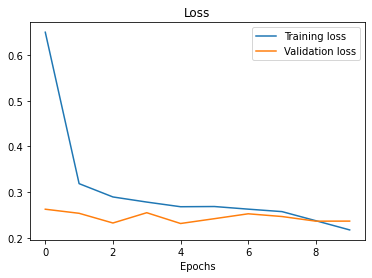

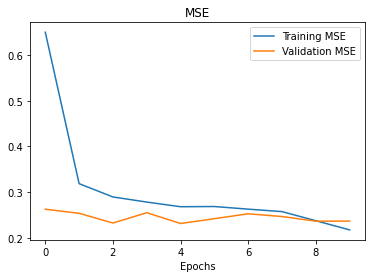

In [24]:
plot_loss_curves(model_0_history)

# **Experiments to optimize the model**
1. Model_1: Add 1 hidden layer to model_0 to improve bias.
2. Model_2: Add 3 hidden layers to model_0 to improve bias.
3. Model_3: Add 10 training epochs to model_1 to improve bias.
4. Model_4: Add 30 training epochs to model_1 to improve bias.
5. Model_5: Add L2 regularization to the hidden layers in model_4 to improve variance.
6. Model_6: Increase learning rate in model_5 to 0.01 to improve variance.
7. Model_7: Increase learning_rate in model_5 to 0.001 to improve variance.
8. Model_8: Train model_8 for 40 more epochs.
9. Model_9: Add dropout to model_5 (prob = 0.5) to improve variance.
10. Model_10: Add dropout to model_5 (prob = 0.2) to improve variance.
11. Model_11: Double the number of units in the hidden layers of model_5.
12. Model_12: Quadruple the number of units in the hidden layers of model_5.
13. Model_13: Add one hidden layer to model_11.

### Model_1 (Add 1 hidden layer to Model_0 to improve bias)

In [31]:
model_1 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_1.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_1_history  = model_1.fit(x = X_train, 
                               y = y_train, 
                               epochs = 10,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_1")])

Saving TensorBoard log files to: nn-predictions/Model_1/20221229-175728
Epoch 1/10
51/51 [==============================] - 1s 7ms/step - loss: 2.2293 - mse: 2.2293 - val_loss: 0.3098 - val_mse: 0.3098
Epoch 2/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3842 - mse: 0.3842 - val_loss: 0.2824 - val_mse: 0.2824
Epoch 3/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3513 - mse: 0.3513 - val_loss: 0.2619 - val_mse: 0.2619
Epoch 4/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3332 - mse: 0.3332 - val_loss: 0.2610 - val_mse: 0.2610
Epoch 5/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3181 - mse: 0.3181 - val_loss: 0.2523 - val_mse: 0.2523
Epoch 6/10
51/51 [==============================] - 0s 4ms/step - loss: 0.3068 - mse: 0.3068 - val_loss: 0.2427 - val_mse: 0.2427
Epoch 7/10
51/51 [==============================] - 0s 6ms/step - loss: 0.2972 - mse: 0.2972 - val_loss: 0.2374 - val_mse: 0.2374
Epoch 8/10
51/51 [

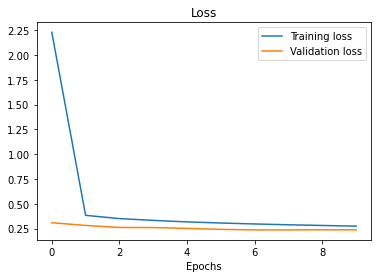

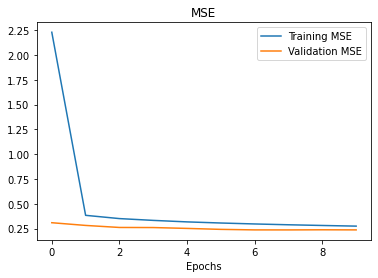

In [32]:
plot_loss_curves(model_1_history)

### Model_2 (Add 3 hidden layers to model_0 to improve bias)

In [33]:
model_2 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_2.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_2_history  = model_2.fit(x = X_train, 
                               y = y_train, 
                               epochs = 10,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_2")])

Saving TensorBoard log files to: nn-predictions/Model_2/20221229-175743
Epoch 1/10
51/51 [==============================] - 3s 22ms/step - loss: 2.6107 - mse: 2.6107 - val_loss: 0.4288 - val_mse: 0.4288
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.3749 - mse: 0.3749 - val_loss: 0.2978 - val_mse: 0.2978
Epoch 3/10
51/51 [==============================] - 1s 11ms/step - loss: 0.3470 - mse: 0.3470 - val_loss: 0.2809 - val_mse: 0.2809
Epoch 4/10
51/51 [==============================] - 1s 11ms/step - loss: 0.3371 - mse: 0.3371 - val_loss: 0.2797 - val_mse: 0.2797
Epoch 5/10
51/51 [==============================] - 0s 10ms/step - loss: 0.3248 - mse: 0.3248 - val_loss: 0.2714 - val_mse: 0.2714
Epoch 6/10
51/51 [==============================] - 1s 10ms/step - loss: 0.3163 - mse: 0.3163 - val_loss: 0.2605 - val_mse: 0.2605
Epoch 7/10
51/51 [==============================] - 1s 12ms/step - loss: 0.3083 - mse: 0.3083 - val_loss: 0.2549 - val_mse: 0.2549
Epoch 8/10
5

### Model_3 (Add 10 training epochs to Model_1 to improve bias)

In [34]:
model_3 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_3.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_3_history  = model_3.fit(x = X_train, 
                               y = y_train, 
                               epochs = 20,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_3")])

Saving TensorBoard log files to: nn-predictions/Model_3/20221229-175755
Epoch 1/20
51/51 [==============================] - 1s 7ms/step - loss: 2.7912 - mse: 2.7912 - val_loss: 0.4193 - val_mse: 0.4193
Epoch 2/20
51/51 [==============================] - 0s 5ms/step - loss: 0.3759 - mse: 0.3759 - val_loss: 0.2983 - val_mse: 0.2983
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3498 - mse: 0.3498 - val_loss: 0.2798 - val_mse: 0.2798
Epoch 4/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3365 - mse: 0.3365 - val_loss: 0.2784 - val_mse: 0.2784
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3224 - mse: 0.3224 - val_loss: 0.2658 - val_mse: 0.2658
Epoch 6/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3118 - mse: 0.3118 - val_loss: 0.2569 - val_mse: 0.2569
Epoch 7/20
51/51 [==============================] - 0s 4ms/step - loss: 0.3022 - mse: 0.3022 - val_loss: 0.2505 - val_mse: 0.2505
Epoch 8/20
51/51 [

### Model_4 (Add 30 training epochs to Model_1 to improve bias)

In [35]:
model_4 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(100, activation = "relu"),
    layers.Dense(1, name = "output_layer")
])

model_4.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_4_history  = model_4.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_4")])

Saving TensorBoard log files to: nn-predictions/Model_4/20221229-175800
Epoch 1/40
51/51 [==============================] - 1s 6ms/step - loss: 1.5368 - mse: 1.5368 - val_loss: 0.2883 - val_mse: 0.2883
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3533 - mse: 0.3533 - val_loss: 0.2831 - val_mse: 0.2831
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3358 - mse: 0.3358 - val_loss: 0.2685 - val_mse: 0.2685
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3244 - mse: 0.3244 - val_loss: 0.2662 - val_mse: 0.2662
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3128 - mse: 0.3128 - val_loss: 0.2619 - val_mse: 0.2619
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3038 - mse: 0.3038 - val_loss: 0.2543 - val_mse: 0.2543
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 0.2964 - mse: 0.2964 - val_loss: 0.2494 - val_mse: 0.2494
Epoch 8/40
51/51 [

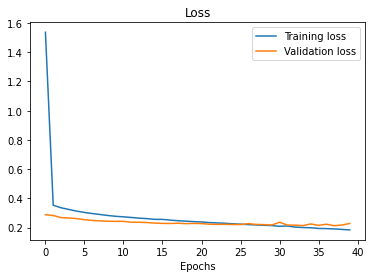

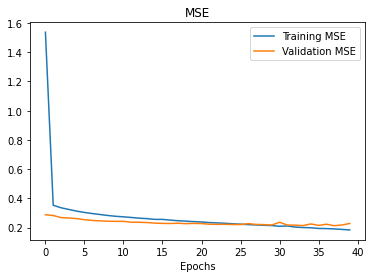

In [36]:
plot_loss_curves(model_4_history)

### Model_5 (Add l2 regularization to the hidden layers in Model_4 to improve variance)

In [37]:
from tensorflow.keras import regularizers

model_5 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_5.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_5_history  = model_5.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_5")])

Saving TensorBoard log files to: nn-predictions/Model_5/20221229-175811
Epoch 1/40
51/51 [==============================] - 1s 7ms/step - loss: 2.9811 - mse: 0.8377 - val_loss: 2.4173 - val_mse: 0.3138
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 2.4230 - mse: 0.3610 - val_loss: 2.3120 - val_mse: 0.2945
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 2.3145 - mse: 0.3382 - val_loss: 2.2097 - val_mse: 0.2773
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 2.2186 - mse: 0.3267 - val_loss: 2.1249 - val_mse: 0.2762
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 2.1249 - mse: 0.3153 - val_loss: 2.0342 - val_mse: 0.2661
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 2.0382 - mse: 0.3077 - val_loss: 1.9495 - val_mse: 0.2588
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 1.9556 - mse: 0.3008 - val_loss: 1.8708 - val_mse: 0.2541
Epoch 8/40
51/51 [

### Model_6 (Increase learning_rate in model_5 to 0.01)


In [38]:
model_6 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_6.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              metrics = ["mse"])

model_6_history  = model_6.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_6")])

Saving TensorBoard log files to: nn-predictions/Model_6/20221229-175821
Epoch 1/40
51/51 [==============================] - 1s 7ms/step - loss: 1.7515 - mse: 0.5676 - val_loss: 0.8857 - val_mse: 0.2524
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 0.7534 - mse: 0.3334 - val_loss: 0.5915 - val_mse: 0.3287
Epoch 3/40
51/51 [==============================] - 0s 3ms/step - loss: 0.4907 - mse: 0.3022 - val_loss: 0.3688 - val_mse: 0.2403
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 0.4313 - mse: 0.3293 - val_loss: 0.3707 - val_mse: 0.2961
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3470 - mse: 0.2875 - val_loss: 0.2891 - val_mse: 0.2438
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 0.3340 - mse: 0.2961 - val_loss: 0.3103 - val_mse: 0.2786
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 0.3077 - mse: 0.2824 - val_loss: 0.3522 - val_mse: 0.3322
Epoch 8/40
51/51 [

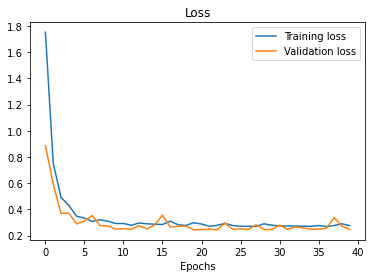

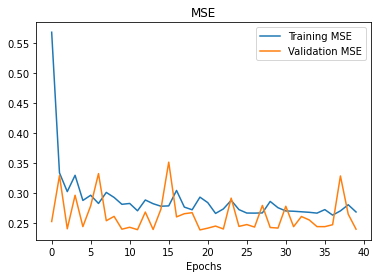

In [39]:
plot_loss_curves(model_6_history)

### Model_7 (Increase learning_rate in model_5 to 0.001)


In [40]:
model_7 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_7.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ["mse"])

model_7_history  = model_7.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_7")])

Saving TensorBoard log files to: nn-predictions/Model_7/20221229-175832
Epoch 1/40
51/51 [==============================] - 1s 7ms/step - loss: 2.5837 - mse: 0.6649 - val_loss: 1.9051 - val_mse: 0.2625
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 1.7495 - mse: 0.3144 - val_loss: 1.5011 - val_mse: 0.2609
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 1.3904 - mse: 0.2907 - val_loss: 1.2034 - val_mse: 0.2359
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 1.1450 - mse: 0.2755 - val_loss: 1.0353 - val_mse: 0.2595
Epoch 5/40
51/51 [==============================] - 0s 3ms/step - loss: 0.9778 - mse: 0.2738 - val_loss: 0.8741 - val_mse: 0.2394
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 0.8618 - mse: 0.2814 - val_loss: 0.7636 - val_mse: 0.2366
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 0.7614 - mse: 0.2765 - val_loss: 0.7161 - val_mse: 0.2740
Epoch 8/40
51/51 [

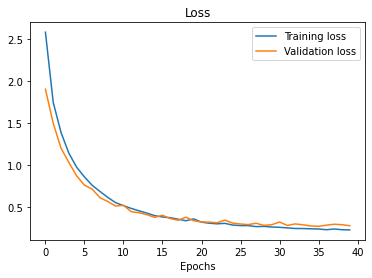

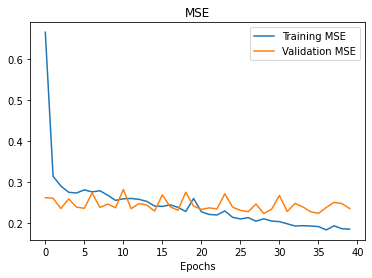

In [41]:
plot_loss_curves(model_7_history)

### Model_8 (Train Model_5 for 40 more epochs)

In [42]:
model_8 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_8.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_8_history  = model_8.fit(x = X_train, 
                               y = y_train, 
                               epochs = 80,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_8")])

Saving TensorBoard log files to: nn-predictions/Model_8/20221229-175843
Epoch 1/80
51/51 [==============================] - 1s 8ms/step - loss: 4.7309 - mse: 2.5841 - val_loss: 2.5273 - val_mse: 0.4094
Epoch 2/80
51/51 [==============================] - 0s 4ms/step - loss: 2.4720 - mse: 0.3855 - val_loss: 2.3557 - val_mse: 0.3046
Epoch 3/80
51/51 [==============================] - 0s 4ms/step - loss: 2.3702 - mse: 0.3523 - val_loss: 2.2627 - val_mse: 0.2803
Epoch 4/80
51/51 [==============================] - 0s 3ms/step - loss: 2.2853 - mse: 0.3362 - val_loss: 2.1865 - val_mse: 0.2730
Epoch 5/80
51/51 [==============================] - 0s 5ms/step - loss: 2.2035 - mse: 0.3226 - val_loss: 2.1084 - val_mse: 0.2623
Epoch 6/80
51/51 [==============================] - 0s 4ms/step - loss: 2.1273 - mse: 0.3130 - val_loss: 2.0362 - val_mse: 0.2557
Epoch 7/80
51/51 [==============================] - 0s 4ms/step - loss: 2.0549 - mse: 0.3054 - val_loss: 1.9668 - val_mse: 0.2500
Epoch 8/80
51/51 [

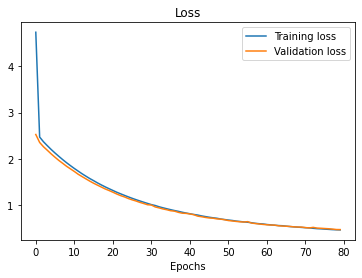

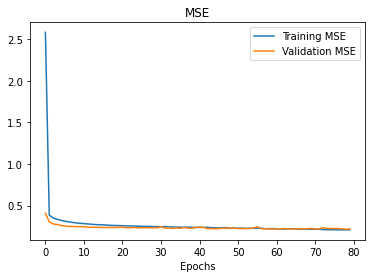

In [43]:
plot_loss_curves(model_8_history)

### Model_9 (Add dropout to Model_5 (prob = 0.5) to improve variance)

In [44]:
model_9 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.5),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_9.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_9_history  = model_9.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_9")])

Saving TensorBoard log files to: nn-predictions/Model_9/20221229-175905
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 4.6184 - mse: 2.4714 - val_loss: 2.4173 - val_mse: 0.2960
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 2.7657 - mse: 0.6728 - val_loss: 2.3494 - val_mse: 0.2881
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 2.6166 - mse: 0.5846 - val_loss: 2.2866 - val_mse: 0.2860
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 2.5337 - mse: 0.5623 - val_loss: 2.2135 - val_mse: 0.2732
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 2.4343 - mse: 0.5224 - val_loss: 2.1533 - val_mse: 0.2720
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 2.3849 - mse: 0.5311 - val_loss: 2.0920 - val_mse: 0.2676
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 2.3084 - mse: 0.5106 - val_loss: 2.0298 - val_mse: 0.2603
Epoch 8/40
51/51 [

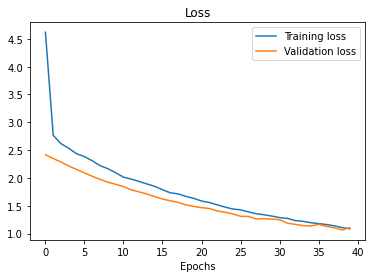

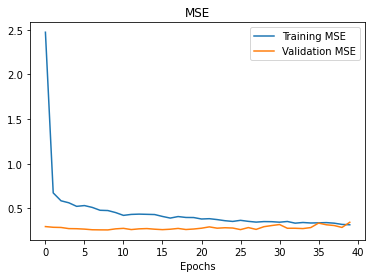

In [45]:
plot_loss_curves(model_9_history)

### Model_10 (Add dropout (prob = 0.2) to Model_5 to improve variance)

In [46]:
model_10 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dropout(0.2),
    layers.Dense(100, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_10.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_10_history  = model_10.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_10")])

Saving TensorBoard log files to: nn-predictions/Model_10/20221229-175916
Epoch 1/40
51/51 [==============================] - 1s 7ms/step - loss: 4.0839 - mse: 1.9155 - val_loss: 2.4775 - val_mse: 0.3395
Epoch 2/40
51/51 [==============================] - 0s 3ms/step - loss: 2.5664 - mse: 0.4614 - val_loss: 2.3870 - val_mse: 0.3178
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 2.4963 - mse: 0.4602 - val_loss: 2.2952 - val_mse: 0.2943
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 2.3915 - mse: 0.4232 - val_loss: 2.2180 - val_mse: 0.2844
Epoch 5/40
51/51 [==============================] - 0s 4ms/step - loss: 2.2929 - mse: 0.3908 - val_loss: 2.1388 - val_mse: 0.2703
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 2.2023 - mse: 0.3643 - val_loss: 2.0670 - val_mse: 0.2613
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 2.1397 - mse: 0.3634 - val_loss: 2.0016 - val_mse: 0.2563
Epoch 8/40
51/51 

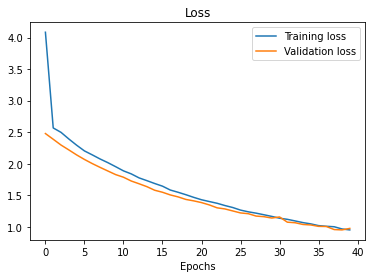

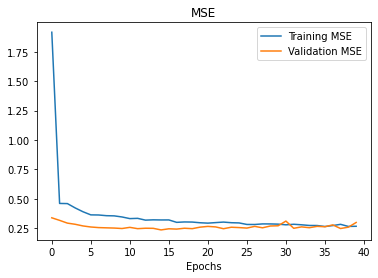

In [47]:
plot_loss_curves(model_10_history)

### Model_11 (Double the number of units in the hidden layers of Model_5)

In [48]:
model_11 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_11.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_11_history  = model_11.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_11")])

Saving TensorBoard log files to: nn-predictions/Model_11/20221229-175928
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 4.6288 - mse: 1.0329 - val_loss: 3.8130 - val_mse: 0.3046
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 3.7900 - mse: 0.3694 - val_loss: 3.6130 - val_mse: 0.2865
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 3.5809 - mse: 0.3406 - val_loss: 3.4084 - val_mse: 0.2596
Epoch 4/40
51/51 [==============================] - 0s 4ms/step - loss: 3.3876 - mse: 0.3220 - val_loss: 3.2373 - val_mse: 0.2597
Epoch 5/40
51/51 [==============================] - 0s 5ms/step - loss: 3.2041 - mse: 0.3054 - val_loss: 3.0611 - val_mse: 0.2457
Epoch 6/40
51/51 [==============================] - 0s 4ms/step - loss: 3.0356 - mse: 0.2946 - val_loss: 2.9004 - val_mse: 0.2377
Epoch 7/40
51/51 [==============================] - 0s 4ms/step - loss: 2.8788 - mse: 0.2863 - val_loss: 2.7540 - val_mse: 0.2352
Epoch 8/40
51/51 

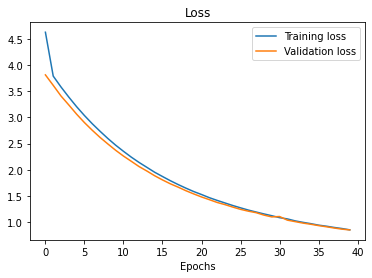

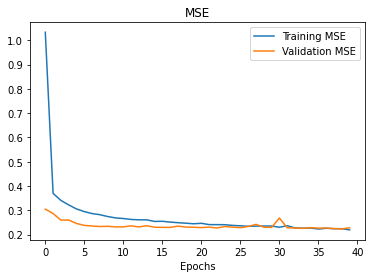

In [49]:
plot_loss_curves(model_11_history)

### Model_12 (Quadruple the number of units in the hidden layers of Model_5)

In [50]:
model_12 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(400, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(400, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_12.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_12_history  = model_12.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_12")])

Saving TensorBoard log files to: nn-predictions/Model_12/20221229-175939
Epoch 1/40
51/51 [==============================] - 1s 11ms/step - loss: 6.7359 - mse: 0.8279 - val_loss: 5.9572 - val_mse: 0.2954
Epoch 2/40
51/51 [==============================] - 0s 9ms/step - loss: 5.7743 - mse: 0.3456 - val_loss: 5.4554 - val_mse: 0.2738
Epoch 3/40
51/51 [==============================] - 0s 8ms/step - loss: 5.2863 - mse: 0.3246 - val_loss: 4.9841 - val_mse: 0.2521
Epoch 4/40
51/51 [==============================] - 0s 7ms/step - loss: 4.8405 - mse: 0.3114 - val_loss: 4.5787 - val_mse: 0.2608
Epoch 5/40
51/51 [==============================] - 0s 7ms/step - loss: 4.4315 - mse: 0.2975 - val_loss: 4.1881 - val_mse: 0.2459
Epoch 6/40
51/51 [==============================] - 0s 8ms/step - loss: 4.0653 - mse: 0.2894 - val_loss: 3.8374 - val_mse: 0.2341
Epoch 7/40
51/51 [==============================] - 0s 7ms/step - loss: 3.7345 - mse: 0.2813 - val_loss: 3.5300 - val_mse: 0.2323
Epoch 8/40
51/51

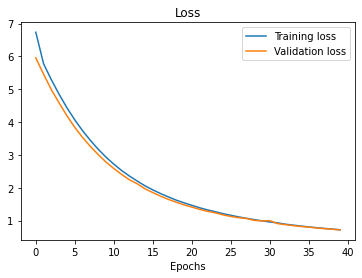

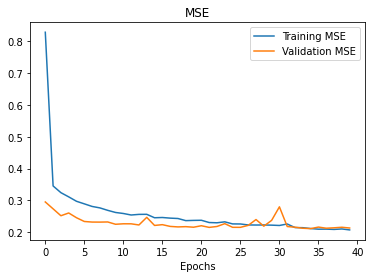

In [51]:
plot_loss_curves(model_12_history)

### Model_13 (Add one hidden layer to Model_11)

In [52]:
model_13 = tf.keras.Sequential([
    layers.Dense(143, input_shape = X_train[0].shape, name = "input_layer"),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(200, activation = "relu", kernel_regularizer = regularizers.L2(l2 = 0.01)),
    layers.Dense(1, name = "output_layer")
])

model_13.compile(loss = tf.keras.losses.mse,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ["mse"])

model_13_history  = model_13.fit(x = X_train, 
                               y = y_train, 
                               epochs = 40,
                               validation_data = (X_val, y_val),
                               callbacks = [create_tensorboard_callback(dir_name = "nn-predictions",
                                                   experiment_name = "Model_13")])

Saving TensorBoard log files to: nn-predictions/Model_13/20221229-180001
Epoch 1/40
51/51 [==============================] - 1s 8ms/step - loss: 7.1368 - mse: 1.5841 - val_loss: 5.7031 - val_mse: 0.3103
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 5.5797 - mse: 0.3468 - val_loss: 5.3430 - val_mse: 0.2802
Epoch 3/40
51/51 [==============================] - 0s 5ms/step - loss: 5.2326 - mse: 0.3243 - val_loss: 5.0045 - val_mse: 0.2595
Epoch 4/40
51/51 [==============================] - 0s 6ms/step - loss: 4.9116 - mse: 0.3144 - val_loss: 4.7106 - val_mse: 0.2691
Epoch 5/40
51/51 [==============================] - 0s 5ms/step - loss: 4.6051 - mse: 0.3020 - val_loss: 4.4107 - val_mse: 0.2537
Epoch 6/40
51/51 [==============================] - 0s 5ms/step - loss: 4.3216 - mse: 0.2944 - val_loss: 4.1347 - val_mse: 0.2436
Epoch 7/40
51/51 [==============================] - 0s 5ms/step - loss: 4.0573 - mse: 0.2875 - val_loss: 3.8835 - val_mse: 0.2405
Epoch 8/40
51/51 

# **Conclusions**

## Comparison of experiment results using TensorBoard

Results can be viewed [here](https://tensorboard.dev/experiment/17PkL7o2Tn65DBujAakWiw/).


In [53]:
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./nn-predictions/ \
--name "NN regressors for length of hospital stay" \
--description "Improvement of the NN model" \
--one_shot

2022-12-29 18:01:33.816822: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./nn-predictions/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%

## Final_model

Based on TensorBoard, Model_12 is the best model

In [56]:
model_12.evaluate(X_test, y_test)

7/7 [==============================] - 0s 5ms/step - loss: 0.7749 - mse: 0.2741


[0.7748507261276245, 0.2740722596645355]